In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import random
import glob
from tqdm import tqdm
from functools import partial
import ot
from matplotlib import pyplot as plt
from collections import defaultdict
import torch, torch.nn as nn
from torch.distributions import Normal
from easydict import EasyDict as edict

In [3]:
from iterative_sir.toy_examples_utils.toy_examples_utils import prepare_swissroll_data
from iterative_sir.toy_examples_utils.gan_fc_models import (
    Generator_fc, 
    Discriminator_fc,
    )
from iterative_sir.sampling_utils.visualization import (
                           sample_fake_data,
                           plot_discriminator_2d,
                           mh_sampling_plot_2d,
                           langevin_sampling_plot_2d,
                           mala_sampling_plot_2d,
                           plot_chain_metrics)
from iterative_sir.sampling_utils.ebm_sampling import (
                          langevin_sampling,
                          mala_dynamics, 
                          mala_sampling,
                          gan_energy,
                          IndependentNormal)
from iterative_sir.sampling_utils.adaptive_mc import ex2_mcmc_mala
from iterative_sir.toy_examples_utils.params_swissroll_wasserstein import (random_seed,
                                          train_dataset_size,
                                          n_dim,
                                          n_layers_d,
                                          n_layers_g,
                                          n_hid_d,
                                          n_hid_g,
                                          n_out,
                                          device)

from iterative_sir.sampling_utils.metrics import Evolution

In [4]:
from pathlib import Path

figpath = Path('../figs')

assert figpath.exists()

# Swissroll, Gaussians

In [5]:
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

X_train = prepare_swissroll_data(train_dataset_size)
X_train_std = X_train

In [6]:
G = Generator_fc(n_dim=n_dim, 
                 n_layers=n_layers_g,
                 n_hid=n_hid_g,
                 n_out=n_out,
                 non_linear=nn.ReLU(),
                 device=device)
D = Discriminator_fc(n_in=n_dim, 
                     n_layers=n_layers_d,
                     n_hid=n_hid_d,
                     non_linear=nn.ReLU(),
                     device=device)

In [7]:
# discriminator_regexp = os.path.join(models_swissroll_path, "*_discriminator.pth")
# generator_regexp = os.path.join(models_swissroll_path, "*_generator.pth")
# discriminator_name = [f for f in glob.glob(discriminator_regexp)][0]
# generator_name = [f for f in glob.glob(generator_regexp)][0]


In [8]:
gen_path = sorted(Path('../models/models_swissroll/wasserstein').glob('*_generator.pth'))[0]
disc_path = sorted(Path('../models/models_swissroll/wasserstein').glob('*_discriminator.pth'))[0]

G.load_state_dict(torch.load(gen_path, map_location=device))
D.load_state_dict(torch.load(disc_path, map_location=device))

<All keys matched successfully>

In [9]:
G = G.to(device)
D = D.to(device)
G.z_dim = G.n_dim

In [10]:
for p in D.parameters():  
    p.requires_grad = False
for p in G.parameters():  
    p.requires_grad = False

In [11]:
# batch_size_sample = 10000
# x_range = 3.0
# y_range = 3.0
# #path_to_final_save = Path(figpath, 'swissroll_gan_samples.pdf')
# #path_to_save = figpath
# path_to_save = None
# path_to_final_save = None
# sample_fake_data(G, X_train,
#                  x_range,
#                  y_range,
#                  path_to_save = path_to_save,
#                  path_to_final_save = path_to_final_save,
#                  batch_size_sample = batch_size_sample)

In [12]:
# x_range = 3.0
# y_range = 3.0
# plot_discriminator_2d(D,
#                       x_range,
#                       y_range,
#                       path_to_save=Path(figpath, 'swissroll_gan_discriminator.pdf'),
#                       normalize_to_0_1=False,
#                       num_points = 700)

In [13]:
# n_calib_pts = 10000
# type_calibrator = 'iso'
# # normalize_to_0_1 = True
# n_steps = 1000
# mh_sampling_plot_2d(G, 
#                     D,
#                     X_train, 
#                     n_steps,
#                     n_calib_pts = n_calib_pts,
#                     batch_size_sample = batch_size_sample,
#                     type_calibrator = type_calibrator,
#                     path_to_save=Path(figpath, 'swissroll_mhgan.pdf'))

In [14]:
# n_calib_pts = 10000
# type_calibrator = 'isotonic'
# normalize_to_0_1 = False
# n_steps = 1000
# mh_sampling_plot_2d(G, 
#                     D,
#                     X_train, 
#                     n_steps,
#                     n_calib_pts = n_calib_pts,
#                     batch_size_sample = batch_size_sample,
#                     type_calibrator = type_calibrator)

In [15]:
# n_calib_pts = 10000
# type_calibrator = 'linear'
# normalize_to_0_1 = False
# n_steps = 1000
# mh_sampling_plot_2d(G, 
#                     D,
#                     X_train, 
#                     n_steps,
#                     n_calib_pts = n_calib_pts,
#                     batch_size_sample = batch_size_sample,
#                     type_calibrator = type_calibrator)

In [16]:
n_dim = G.n_dim
loc = torch.zeros(n_dim).to(G.device)
scale = torch.ones(n_dim).to(G.device)
normal = Normal(loc, scale)
normalize_to_0_1 = True 
log_prob = True

proposal = IndependentNormal(
    dim=n_dim,
    device=device,
    loc=loc,
    scale=scale)

target = partial(gan_energy, 
                     generator = G, 
                     discriminator = D, 
                     proposal = proposal,
                     normalize_to_0_1 = normalize_to_0_1,
                     log_prob = log_prob)

In [17]:
evols = dict()

In [28]:
batch_size = 1 #25 #5000
n_steps = 800
every = 200

In [29]:
target_sample = X_train[np.random.choice(np.arange(X_train.shape[0]), 1000)]

grad_step = 1e-1 #3e-3
eps_scale = (grad_step * 2) ** 0.5

z_last_np, zs = langevin_sampling(target,
                               proposal,  
                               batch_size=batch_size,
                               n = batch_size,
                               grad_step = grad_step,
                               eps_scale = eps_scale,
                               n_steps = n_steps)

n_chunks = len(zs[0]) // every
zs = zs[0, -n_chunks * every:].reshape((n_chunks, batch_size, -1, zs.shape[-1]))
zs_gen = zs.reshape(batch_size, n_chunks, -1, zs.shape[-1])

Xs_gen = G(torch.FloatTensor(zs_gen).to(device)).detach().cpu().numpy()
#Xs_gen = scaler.inverse_transform(Xs_gen.reshape(-1, Xs_gen.shape[-1])).reshape(Xs_gen.shape)

evol = defaultdict(list)
for X_gen in Xs_gen:
    evolution = Evolution(target_sample,
                      target_log_prob=target)
    for chunk in X_gen:
        evolution.invoke(torch.FloatTensor(chunk))
    evol_ = evolution.as_dict()
    for k, v in evol_.items():
        evol[k].append(v)

for k, v in evol.items():
    evol[k] = (np.mean(np.array(v), 0), np.std(np.array(v), 0, ddof=1) / np.sqrt(batch_size))
evols['ULA'] = evol

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
/home/evgeny/.local/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/evgeny/.local/lib/python3.8/site-packages/numpy/core/_methods.py:251: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


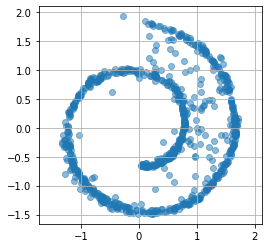

In [30]:
chain_id = 0 #10
x = Xs_gen[chain_id][-500:]
plt.figure(figsize=(4,4))
plt.scatter(x[..., 0], x[..., 1], alpha=0.5)
plt.axis('equal')
plt.grid()
plt.show()

In [31]:
from iterative_sir.sampling_utils.adaptive_mc import ex2_mcmc_mala

target_sample = X_train[np.random.choice(np.arange(X_train.shape[0]), 1000)]

grad_step = 1e-2
eps_scale = (grad_step * 2) ** 0.5

N = 10
corr_coef = 0.9
bernoulli_prob_corr = 0.5
mala_steps = 1

z_0 = proposal.sample((batch_size,))
zs = ex2_mcmc_mala(z_0,
                    target,
                    proposal,
                    n_steps,
                    N, 
                    grad_step = grad_step,
                    noise_scale = eps_scale,
                    corr_coef=corr_coef,
                    bernoulli_prob_corr=bernoulli_prob_corr,
                    adapt_stepsize=True,
                    mala_steps = mala_steps,
                    verbose=True)
zs = zs[0]
n_chunks = len(zs) // every
zs = torch.stack(zs, 0).detach().numpy()
zs = zs[-n_chunks * every:].reshape((n_chunks, batch_size, -1, zs.shape[-1]))
#zs = zs[0, ::every]
zs_gen = zs.reshape(batch_size, n_chunks, -1, zs.shape[-1])

Xs_gen = G(torch.FloatTensor(zs_gen).to(device)).detach().cpu().numpy()
#Xs_gen = scaler.inverse_transform(Xs_gen.reshape(-1, Xs_gen.shape[-1])).reshape(Xs_gen.shape)

evol = defaultdict(list)
for X_gen in Xs_gen:
    evolution = Evolution(target_sample, 
                      target_log_prob=target)
    for chunk in X_gen:
        evolution.invoke(torch.FloatTensor(chunk))
    evol_ = evolution.as_dict()
    for k, v in evol_.items():
        evol[k].append(v)

for k, v in evol.items():
    evol[k] = (np.mean(np.array(v), 0), np.std(np.array(v), 0, ddof=1) / np.sqrt(batch_size))
evols['Ex$^2$MCMC-MALA'] = evol

100%|██████████| 800/800 [00:04<00:00, 167.84it/s]
/home/evgeny/gans_sampling/iterative_sir/sampling_utils/metrics.py:313: RuntimeWarning: invalid value encountered in multiply
  kl = pi_g * (np.log(pi_g) - np.log(pi_d + 1e-10))
/home/evgeny/gans_sampling/iterative_sir/sampling_utils/metrics.py:320: RuntimeWarning: invalid value encountered in multiply
  pi_g * (np.log(pi_g) - np.log(m))
/home/evgeny/gans_sampling/iterative_sir/sampling_utils/metrics.py:313: RuntimeWarning: invalid value encountered in multiply
  kl = pi_g * (np.log(pi_g) - np.log(pi_d + 1e-10))
/home/evgeny/gans_sampling/iterative_sir/sampling_utils/metrics.py:320: RuntimeWarning: invalid value encountered in multiply
  pi_g * (np.log(pi_g) - np.log(m))
/home/evgeny/gans_sampling/iterative_sir/sampling_utils/metrics.py:313: RuntimeWarning: invalid value encountered in multiply
  kl = pi_g * (np.log(pi_g) - np.log(pi_d + 1e-10))
/home/evgeny/gans_sampling/iterative_sir/sampling_utils/metrics.py:320: RuntimeWarning: inv

In [32]:
from iterative_sir.sampling_utils.adaptive_mc import ex2_mcmc_mala

target_sample = X_train[np.random.choice(np.arange(X_train.shape[0]), 1000)]

grad_step = 1e-2
eps_scale = (grad_step * 2) ** 0.5

z_0 = proposal.sample((batch_size,))
zs = mala_dynamics(z_0,
        target,
        proposal,
        n_steps,
        grad_step = grad_step,
        eps_scale = eps_scale,
        adapt_stepsize=True)
zs = zs[0]
n_chunks = len(zs) // every
zs = torch.stack(zs, 0).detach().numpy()
zs = zs[-n_chunks * every:].reshape((n_chunks, batch_size, -1, zs.shape[-1]))
#zs = zs[0, ::every]
zs_gen = zs.reshape(batch_size, n_chunks, -1, zs.shape[-1])

Xs_gen = G(torch.FloatTensor(zs_gen).to(device)).detach().cpu().numpy()
#Xs_gen = scaler.inverse_transform(Xs_gen.reshape(-1, Xs_gen.shape[-1])).reshape(Xs_gen.shape)

evol = defaultdict(list)
for X_gen in Xs_gen:
    evolution = Evolution(target_sample, 
                      target_log_prob=target)
    for chunk in X_gen:
        evolution.invoke(torch.FloatTensor(chunk))
    evol_ = evolution.as_dict()
    for k, v in evol_.items():
        evol[k].append(v)

for k, v in evol.items():
    evol[k] = (np.mean(np.array(v), 0), np.std(np.array(v), 0, ddof=1) / np.sqrt(batch_size))
evols['MALA'] = evol

/home/evgeny/gans_sampling/iterative_sir/sampling_utils/metrics.py:313: RuntimeWarning: invalid value encountered in multiply
  kl = pi_g * (np.log(pi_g) - np.log(pi_d + 1e-10))
/home/evgeny/gans_sampling/iterative_sir/sampling_utils/metrics.py:320: RuntimeWarning: invalid value encountered in multiply
  pi_g * (np.log(pi_g) - np.log(m))
/home/evgeny/gans_sampling/iterative_sir/sampling_utils/metrics.py:313: RuntimeWarning: invalid value encountered in multiply
  kl = pi_g * (np.log(pi_g) - np.log(pi_d + 1e-10))
/home/evgeny/gans_sampling/iterative_sir/sampling_utils/metrics.py:320: RuntimeWarning: invalid value encountered in multiply
  pi_g * (np.log(pi_g) - np.log(m))
/home/evgeny/.local/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/evgeny/.local/lib/python3.8/site-packages/numpy/core/_methods.py:251: RuntimeWarning: invalid value encountered in true_divide
 

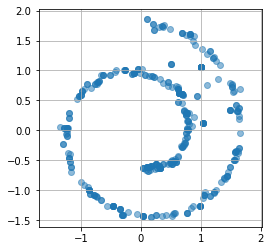

In [34]:
chain_id = 0
x = Xs_gen[chain_id]
plt.figure(figsize=(4,4))
plt.scatter(x[2:, ..., 0], x[2:, ..., 1], alpha=0.5)
plt.axis('equal')
plt.grid()
plt.show()

In [30]:
Xs_gen.shape

(25, 8, 100, 2)

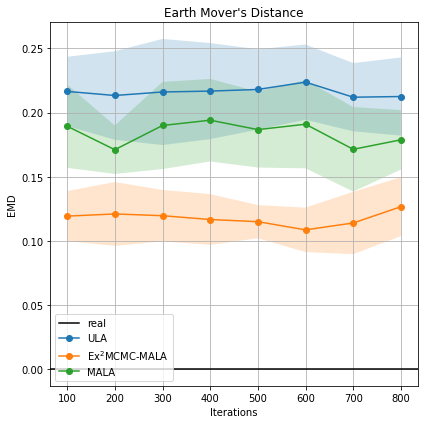

In [28]:
plot_chain_metrics(evols, every=every, keys=['emd'], sigma=None)

In [ ]:
# grad_step = 1e-4
# eps_scale = 1e-3
# n_steps = 400
# n_batches = 10
# langevin_sampling_plot_2d(target_gan,
#                           proposal,
#                           X_train,  
#                           batch_size_sample = batch_size_sample,
#                           grad_step = grad_step,
#                           eps_scale = eps_scale,
#                           n_steps = n_steps,
#                           n_batches = n_batches,
#                           latent_transform = G,
#                           path_to_save=Path(figpath, 'swissroll_ula.pdf'))

In [ ]:
# grad_step = 1e-4
# eps_scale = 1e-3
# n_steps = 400
# n_batches = 10
# langevin_sampling_plot_2d(target_gan,
#                           proposal,
#                           X_train,  
#                           batch_size_sample = batch_size_sample,
#                           grad_step = grad_step,
#                           eps_scale = eps_scale,
#                           n_steps = n_steps,
#                           n_batches = n_batches,
#                           latent_transform = G)

In [ ]:
# target_sample = X_train[np.random.choice(np.arange(X_train.shape[0]), 1000)]

# evolution = Evolution(target_sample)

# n_steps = 500
# every = 50

# z_last_np, zs = mala_sampling(target_gan,
#                                proposal,  
#                                batch_size=batch_size_sample,
#                                n = batch_size_sample,
#                                grad_step = grad_step,
#                                eps_scale = eps_scale,
#                                n_steps = n_steps,
#                                acceptance_rule = 'Hastings')#,
#                                #n_batches = n_batches)

# zs = zs[0, ::every]
# Xs_gen = zs

# Xs_gen = G(torch.FloatTensor(zs, device=device)).detach().cpu().numpy()
# #Xs_gen = scaler.inverse_transform(Xs_gen.reshape(-1, Xs_gen.shape[-1])).reshape(Xs_gen.shape)

# for X_gen in Xs_gen:
#     evolution.invoke(torch.FloatTensor(X_gen))
# evol = evolution.as_dict()
# evols[f'MALA, MH'] = evol

In [ ]:
# grad_step = 1e-4
# eps_scale = (2*grad_step)**0.5
# n_steps = 100
# n_batches = 10
# acceptance_rule = 'Hastings'
# mala_sampling_plot_2d(target_gan,
#                       proposal,
#                       X_train,   
#                       batch_size_sample = batch_size_sample,
#                       grad_step = grad_step,
#                       eps_scale = eps_scale,
#                       n_steps = n_steps,
#                       n_batches = n_batches,
#                       acceptance_rule = acceptance_rule,
#                       latent_transform = G)

In [ ]:
# grad_step = 1e-3
# eps_scale = 1e-2
# n_steps = 100
# n_batches = 10
# acceptance_rule = 'Barker'
# mala_sampling_plot_2d(target_gan,
#                       proposal,
#                       X_train,  
#                       batch_size_sample = batch_size_sample,
#                       grad_step = grad_step,
#                       eps_scale = eps_scale,
#                       n_steps = n_steps,
#                       n_batches = n_batches,
#                       acceptance_rule = acceptance_rule,
#                       latent_transform = G)

In [ ]:
# evols = dict()

In [ ]:
# target_sample = X_train[np.random.choice(np.arange(X_train.shape[0]), 1000)]

# evolution = Evolution(target_sample)

# n_steps = 500
# every = 50

# z_last_np, zs = mala_sampling(target_gan,
#                                proposal,  
#                                batch_size=batch_size_sample,
#                                n = batch_size_sample,
#                                grad_step = grad_step,
#                                eps_scale = eps_scale,
#                                n_steps = n_steps,
#                                acceptance_rule = 'Hastings')#,
#                                #n_batches = n_batches)

# zs = zs[0, ::every]
# Xs_gen = zs

# Xs_gen = G(torch.FloatTensor(zs, device=device)).detach().cpu().numpy()
# #Xs_gen = scaler.inverse_transform(Xs_gen.reshape(-1, Xs_gen.shape[-1])).reshape(Xs_gen.shape)

# for X_gen in Xs_gen:
#     evolution.invoke(torch.FloatTensor(X_gen))
# evol = evolution.as_dict()
# evols[f'MALA, MH'] = evol

In [ ]:
# plot_chain_metrics(**evols, every=every, savepath=Path(figpath, '2d_swissroll_gan_chain_metrics.pdf'))